<a href="https://colab.research.google.com/github/james130625/notebook/blob/main/Feature_Importances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.6/46.6 kB 2.1 MB/s eta 0:00:00


Accuracy: 0.8696886626199334
Precision: 0.11896551724137931
Recall: 0.3087248322147651


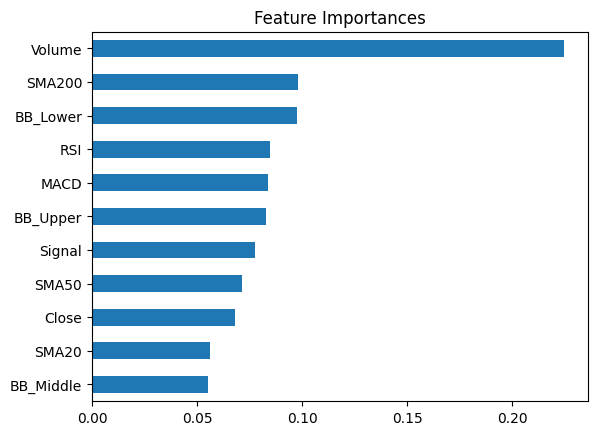

추천된 급등주 종목:
              Code  Close    Volume
Date                               
2024-05-24  103840   6700  26886973
2024-05-07  147830   7050  11172901
2024-05-10  054780   6930   8097478
2024-01-15  067900   7800   7570771
2024-05-29  051980   9390   7288122
2024-05-28  033790   6590   6260925
2024-05-29  366030   6560   5891318
2023-11-08  054670   9500   5785610
2024-05-23  215100   6300   5742162
2024-05-29  323280   5680   5169241


In [ ]:
# 필요한 패키지 설치
!pip install finance-datareader
!pip install imbalanced-learn

import FinanceDataReader as fdr
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

plt.rcParams['font.family'] = 'NanumBarunGothic'

# 데이터 수집
kosdaq_list = fdr.StockListing('KOSDAQ')
start_date = '2023-01-02'
end_date = datetime.today().strftime('%Y-%m-%d')

# 기술적 지표 계산 함수
def calculate_technical_indicators(data):
    # 이동 평균 계산
    data['SMA20'] = data['Close'].rolling(window=20).mean()
    data['SMA50'] = data['Close'].rolling(window=50).mean()
    data['SMA200'] = data['Close'].rolling(window=200).mean()

    # MACD 계산
    data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA12'] - data['EMA26']
    data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # RSI 계산
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # 볼린저 밴드 계산
    data['BB_Middle'] = data['Close'].rolling(window=20).mean()
    data['BB_Upper'] = data['BB_Middle'] + 2 * data['Close'].rolling(window=20).std()
    data['BB_Lower'] = data['BB_Middle'] - 2 * data['Close'].rolling(window=20).std()

    return data

# 급등주 레이블 생성 함수
def create_label(data, threshold=0.05):
    data['Label'] = (data['Close'].shift(-1) - data['Close']) / data['Close'] > threshold
    data['Label'] = data['Label'].astype(int)
    return data

# 각 종목의 데이터를 가져와서 전처리 및 특징 추출
filtered_stocks_data = []
for code in kosdaq_list['Code']:
    try:
        data = fdr.DataReader(code, start_date, end_date)
        if data['Close'].iloc[-1] >= 5000 and data['Close'].iloc[-1] <= 10000:
            data = calculate_technical_indicators(data)
            data = create_label(data)
            data['Code'] = code
            filtered_stocks_data.append(data)
    except Exception as e:
        print(f"Failed to process {code}: {e}")
        continue

# 데이터프레임으로 통합
all_data_df = pd.concat(filtered_stocks_data)

# 결측치 제거
all_data_df.dropna(inplace=True)

# 특징과 레이블 설정
features = ['Close', 'Volume', 'SMA20', 'SMA50', 'SMA200', 'MACD', 'Signal', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower']
X = all_data_df[features]
y = all_data_df['Label']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 오버샘플링
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)

# 예측 및 평가
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# 중요 특징 시각화
feature_importances = pd.Series(model.feature_importances_, index=features)
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importances')
plt.show()

# 급등주 예측
predicted_data = all_data_df.copy()
predicted_data['Prediction'] = model.predict(X)

# 예측된 급등주 중 상위 10개 종목 추천
predicted_gainers = predicted_data[predicted_data['Prediction'] == 1]
top_10_gainers = predicted_gainers.groupby('Code').tail(1).sort_values(by='Volume', ascending=False).head(10)

print("추천된 급등주 종목:")
print(top_10_gainers[['Code', 'Close', 'Volume']])


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.6/46.6 kB 1.2 MB/s eta 0:00:00


<ipython-input-1-36b389386124>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SMA20'] = data['Close'].rolling(window=20).mean()
<ipython-input-1-36b389386124>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SMA50'] = data['Close'].rolling(window=50).mean()
<ipython-input-1-36b389386124>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

Accuracy: 0.8766259361450532
Precision: 0.12640449438202248
Recall: 0.2973568281938326


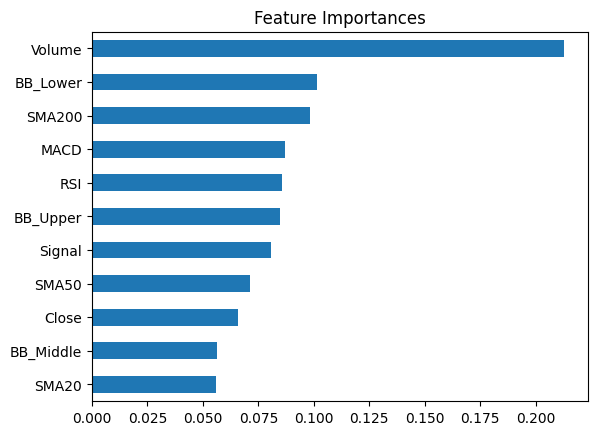

추천된 급등주 종목:
              Code  Close    Volume
Date                               
2024-05-29  298830   6610  12159639
2024-05-27  051980   8890   9822845
2024-01-15  067900   7800   7570771
2024-05-17  103840   4830   6206148
2024-05-29  323280   5680   5169241
2024-04-24  053450   7680   4955915
2024-05-21  038460   6220   4141986
2024-05-29  189860   7020   4099236
2024-05-22  260930   6890   3607592
2024-04-11  256840   6200   2921627


In [ ]:
# 필요한 패키지 설치
!pip install finance-datareader
!pip install imbalanced-learn

import FinanceDataReader as fdr
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

plt.rcParams['font.family'] = 'NanumBarunGothic'

# 데이터 수집
kosdaq_list = fdr.StockListing('KOSDAQ')
start_date = '2023-01-02'
end_date = datetime.today().strftime('%Y-%m-%d')

# 기술적 지표 계산 함수
def calculate_technical_indicators(data):
    # 이동 평균 계산
    data['SMA20'] = data['Close'].rolling(window=20).mean()
    data['SMA50'] = data['Close'].rolling(window=50).mean()
    data['SMA200'] = data['Close'].rolling(window=200).mean()

    # MACD 계산
    data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA12'] - data['EMA26']
    data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # RSI 계산
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # 볼린저 밴드 계산
    data['BB_Middle'] = data['Close'].rolling(window=20).mean()
    data['BB_Upper'] = data['BB_Middle'] + 2 * data['Close'].rolling(window=20).std()
    data['BB_Lower'] = data['BB_Middle'] - 2 * data['Close'].rolling(window=20).std()

    return data

# 급등주 레이블 생성 함수
def create_label(data, threshold=0.05):
    data['Label'] = (data['Close'].shift(-1) - data['Close']) / data['Close'] > threshold
    data['Label'] = data['Label'].astype(int)
    return data

# 각 종목의 데이터를 가져와서 전처리 및 특징 추출
filtered_stocks_data = []
for code in kosdaq_list['Code']:
    try:
        data = fdr.DataReader(code, start_date, end_date)
        if data['Close'].iloc[-1] >= 5000 and data['Close'].iloc[-1] <= 10000:
            data = calculate_technical_indicators(data)
            data = create_label(data)
            data['Code'] = code
            filtered_stocks_data.append(data)
    except Exception as e:
        print(f"Failed to process {code}: {e}")
        continue

# 데이터프레임으로 통합
all_data_df = pd.concat(filtered_stocks_data)

# 결측치 제거
all_data_df.dropna(inplace=True)

# 특징과 레이블 설정
features = ['Close', 'Volume', 'SMA20', 'SMA50', 'SMA200', 'MACD', 'Signal', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower']
X = all_data_df[features]
y = all_data_df['Label']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 오버샘플링
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)

# 예측 및 평가
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# 중요 특징 시각화
feature_importances = pd.Series(model.feature_importances_, index=features)
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importances')
plt.show()

# 급등주 예측
predicted_data = all_data_df.copy()
predicted_data['Prediction'] = model.predict(X)

# 예측된 급등주 중 상위 10개 종목 추천
predicted_gainers = predicted_data[predicted_data['Prediction'] == 1]
top_10_gainers = predicted_gainers.groupby('Code').tail(1).sort_values(by='Volume', ascending=False).head(10)

print("추천된 급등주 종목:")
print(top_10_gainers[['Code', 'Close', 'Volume']])


<ipython-input-2-58652efdd9ab>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SMA20'] = data['Close'].rolling(window=20).mean()
<ipython-input-2-58652efdd9ab>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SMA50'] = data['Close'].rolling(window=50).mean()
<ipython-input-2-58652efdd9ab>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

Accuracy: 0.8771617748789406
Precision: 0.12112676056338029
Recall: 0.2958715596330275


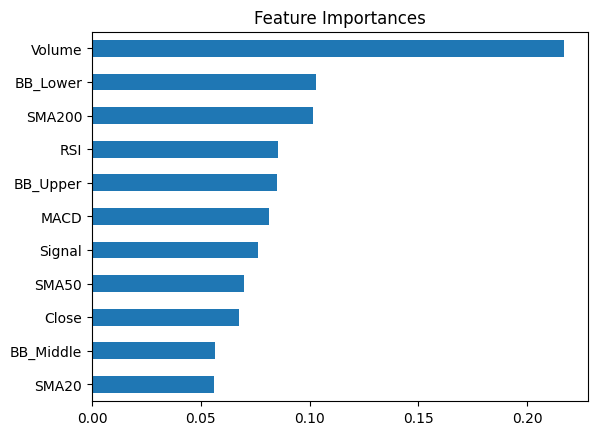

추천된 급등주 종목:
              Code  Close    Volume
Date                               
2024-05-27  298830   6770  33870533
2024-05-14  142210   6680  12631554
2024-02-21  002800   6830  11185331
2024-05-20  033790   6150  10569528
2024-03-22  253840   8100  10517621
2024-05-27  051980   8890   9822845
2024-05-20  006620   7880   8267398
2024-02-27  006140   7230   8162850
2024-04-02  005860   5250   8068773
2024-02-19  047310  15370   7980468
종목 코드: 298830
현재 단계: Eating
실시간 현재가: 6650
최근 종가: 6650
현재 추세: 상승 추세
52주 최고가: 12240.0
52주 최저가: 4280.0
52주 적정 매수가: 8260.0
매수 범위: (4597.38619985512, 7191.61380014488)
1차 매수 목표: 5894.5
2차 매수 목표: 5894.5
3차 매수 목표: 7191.61380014488
익절가: 13464.000000000002
손절가: 4066.0
종목 코드: 142210
현재 단계: Eating
실시간 현재가: 6880
최근 종가: 6880
현재 추세: 상승 추세
52주 최고가: 7720.0
52주 최저가: 3555.0
52주 적정 매수가: 5637.5
매수 범위: (5490.895801466003, 7318.104198533997)
1차 매수 목표: 6404.5
2차 매수 목표: 6404.5
3차 매수 목표: 7318.104198533997
익절가: 8492.0
손절가: 3377.25
종목 코드: 002800
현재 단계: Sleeping
실시간 현재가: 5350
최

In [2]:
# 필요한 패키지 설치
!pip install finance-datareader
!pip install imbalanced-learn

import FinanceDataReader as fdr
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

plt.rcParams['font.family'] = 'NanumBarunGothic'

# 데이터 수집
kosdaq_list = fdr.StockListing('KOSDAQ')
start_date = '2023-01-02'
end_date = datetime.today().strftime('%Y-%m-%d')

# 기술적 지표 계산 함수
def calculate_technical_indicators(data):
    # 이동 평균 계산
    data['SMA20'] = data['Close'].rolling(window=20).mean()
    data['SMA50'] = data['Close'].rolling(window=50).mean()
    data['SMA200'] = data['Close'].rolling(window=200).mean()

    # MACD 계산
    data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA12'] - data['EMA26']
    data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # RSI 계산
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # 볼린저 밴드 계산
    data['BB_Middle'] = data['Close'].rolling(window=20).mean()
    data['BB_Upper'] = data['BB_Middle'] + 2 * data['Close'].rolling(window=20).std()
    data['BB_Lower'] = data['BB_Middle'] - 2 * data['Close'].rolling(window=20).std()

    return data

# 급등주 레이블 생성 함수
def create_label(data, threshold=0.05):
    data['Label'] = (data['Close'].shift(-1) - data['Close']) / data['Close'] > threshold
    data['Label'] = data['Label'].astype(int)
    return data

# 각 종목의 데이터를 가져와서 전처리 및 특징 추출
filtered_stocks_data = []
for code in kosdaq_list['Code']:
    try:
        data = fdr.DataReader(code, start_date, end_date)
        if data['Close'].iloc[-1] >= 5000 and data['Close'].iloc[-1] <= 10000:
            data = calculate_technical_indicators(data)
            data = create_label(data)
            data['Code'] = code
            filtered_stocks_data.append(data)
    except Exception as e:
        print(f"Failed to process {code}: {e}")
        continue

# 데이터프레임으로 통합
all_data_df = pd.concat(filtered_stocks_data)

# 결측치 제거
all_data_df.dropna(inplace=True)

# 특징과 레이블 설정
features = ['Close', 'Volume', 'SMA20', 'SMA50', 'SMA200', 'MACD', 'Signal', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower']
X = all_data_df[features]
y = all_data_df['Label']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 오버샘플링
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)

# 예측 및 평가
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# 중요 특징 시각화
feature_importances = pd.Series(model.feature_importances_, index=features)
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importances')
plt.show()

# 급등주 예측
predicted_data = all_data_df.copy()
predicted_data['Prediction'] = model.predict(X)

# 예측된 급등주 중 상위 10개 종목 추천
predicted_gainers = predicted_data[predicted_data['Prediction'] == 1]
top_10_gainers = predicted_gainers.groupby('Code').tail(1).sort_values(by='Volume', ascending=False).head(10)

print("추천된 급등주 종목:")
print(top_10_gainers[['Code', 'Close', 'Volume']])

# 상위 10개 종목의 상세 정보 출력
for ticker in top_10_gainers['Code']:
    stock_data = fdr.DataReader(ticker, start_date, end_date)
    stock_data = calculate_technical_indicators(stock_data)

    # 최신 데이터 포인트의 단계 표시
    short_ma = stock_data['SMA20']
    long_ma = stock_data['SMA50']
    current_phase = 'Sleeping'
    if short_ma.iloc[-1] > long_ma.iloc[-1]:
        current_phase = 'Awakening' if short_ma.iloc[-2] <= long_ma.iloc[-2] else 'Eating'

    # 실시간 가격 가져오기 (예시로 최근 종가 사용)
    current_price = stock_data['Close'].iloc[-1]

    # 추가 메트릭 계산
    latest_close = stock_data['Close'].iloc[-1]
    current_trend = "상승 추세" if stock_data['SMA20'].iloc[-1] > stock_data['SMA50'].iloc[-1] else "하락 추세"
    fifty_two_week_high = stock_data['Close'].rolling(window=252).max().iloc[-1]
    fifty_two_week_low = stock_data['Close'].rolling(window=252).min().iloc[-1]
    ideal_buy_price = (fifty_two_week_high + fifty_two_week_low) / 2

    # 매수 범위와 목표 정의
    buy_range = (stock_data['BB_Lower'].iloc[-1], stock_data['BB_Upper'].iloc[-1])
    first_buy_target = stock_data['SMA20'].iloc[-1]
    second_buy_target = stock_data['BB_Middle'].iloc[-1]
    third_buy_target = stock_data['BB_Upper'].iloc[-1]
    profit_target = fifty_two_week_high * 1.1
    stop_loss = fifty_two_week_low * 0.95

    # 결과 표시
    print(f"종목 코드: {ticker}")
    print("현재 단계:", current_phase)
    print("실시간 현재가:", current_price)
    print("최근 종가:", latest_close)
    print("현재 추세:", current_trend)
    print("52주 최고가:", fifty_two_week_high)
    print("52주 최저가:", fifty_two_week_low)
    print("52주 적정 매수가:", ideal_buy_price)
    print("매수 범위:", buy_range)
    print("1차 매수 목표:", first_buy_target)
    print("2차 매수 목표:", second_buy_target)
    print("3차 매수 목표:", third_buy_target)
    print("익절가:", profit_target)
    print("손절가:", stop_loss)
    print("="*50)
